<a href="https://colab.research.google.com/github/EddyGiusepe/Studying_spaCy_NER/blob/main/Clinical_NER_other_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font>[Clinical Named Entity Recognition Using spaCy](https://pasaentuciudad.com.mx/clinical-named-entity-recognition-using-spacy/)</font>

Data scientist.: Dr.Eddy Giusepe Chirinos Isidro

In [1]:
# Bibliotecas necessárias

import pandas as pd
import numpy as np


# 1. Preprocessing Dataset

In [2]:
raw_df = pd.read_csv('/content/drive/MyDrive/3_EDDY_ISH_TECNOLOGIA/4_ML_inside_of _MANTIS/1_Tratando_Dados_json_Mantis/Applying_spaCy_to_Mantis/mtsamples.csv', index_col=0)


raw_df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


Existem $40$ categorias únicas de especialidades médicas no conjunto de dados. O número de categorias de especialidades médicas pode ser reduzido de $40$ para as seguintes 9 categorias filtrando o conjunto de dados de várias maneiras:

In [5]:
raw_df['medical_specialty'].unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' SOAP / Chart / Progress Notes', ' Sleep Medicine',
       ' Rheumatology', ' Radiology', ' Psychiatry / Psychology',
       ' Podiatry', ' Physical Medicine - Rehab',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Letters',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Diets and Nutritions', ' Dermatology',
       ' Cosmetic / Plastic Surgery', ' Consult - History and Phy.',
       ' Chiropractic', ' Autopsy'], dtype=object)

In [6]:
# Efetivamente são 40 especialidades:

len(raw_df['medical_specialty'].unique())

40

In [11]:
raw_df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

# 2. Definindo Entidades e Tipos Específicos de Domínio

Um modelo ``NER`` no ``spaCy`` é um modelo de **aprendizado profundo supervisionado**. Assim, as entidades rotuladas são necessárias para cada um dos documentos no conjunto de dados para treinamento e teste do modelo.

Normalmente, uma ferramenta de anotação de texto, como o ``prodigy``, é usada para anotar entidades com tipos em documentos. Este artigo utiliza um método alternativo para gerar automaticamente o conjunto de dados de texto anotado. Para isso, as entidades (não suas localizações nos documentos) e os tipos precisam ser especificados.

Para efeitos de demonstração, assume-se que estamos interessados ​​nas seguintes entidades (doenças ou medicamentos) e tipos (especialidades médicas):

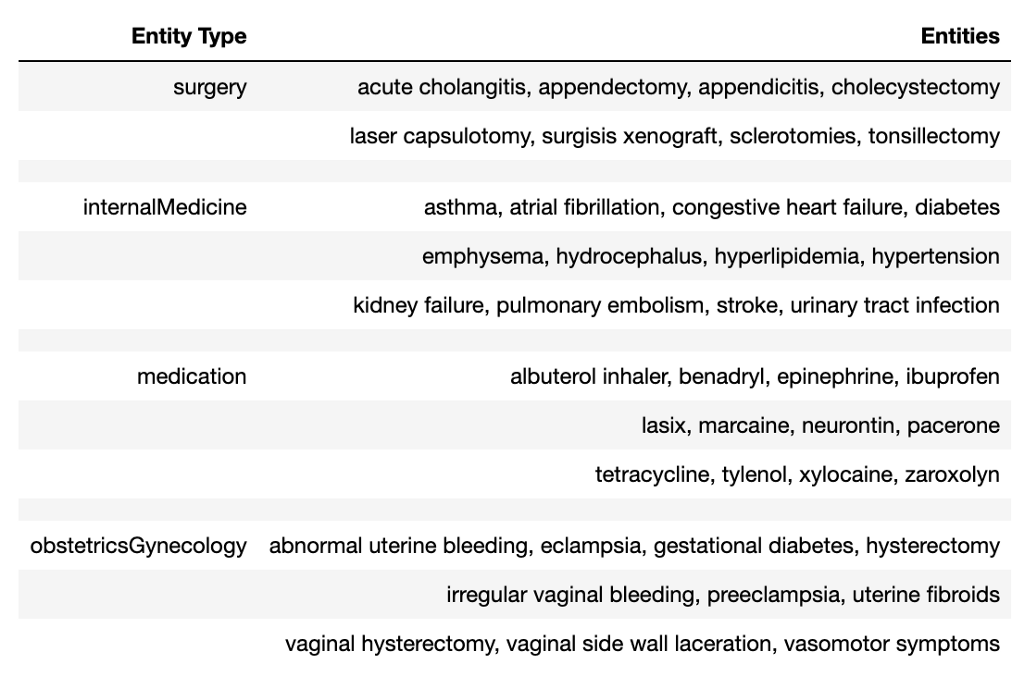

As entidades para cada tipo de entidade são armazenadas como um conjunto na implementação. Como exemplo, o seguinte é o conjunto de cirurgia:

In [12]:
surgery = set(['acute cholangitis', 'appendectomy', 
               'appendicitis', 'cholecystectomy', 
               'laser capsulotomy', 'surgisis xenograft', 
               'sclerotomies', 'tonsillectomy' 
               ])

# 3. Gerando conjunto de Dados anotado

Conforme descrito na seção anterior, para ``treinar`` e ``testar`` um modelo ``spaCy NER``, cada um dos documentos de texto que contêm entidades precisa ser rotulado com anotações de texto no modelo a seguir:

```
(‘document text’, {‘entities’: [(start, end, type), . . . , (start, end, type)]})
```

Uma vez que as entidades e os tipos são identificados (veja a seção anterior), um conjunto de dados de texto anotado pode ser gerado automaticamente da seguinte forma:

* crie um modelo de régua de entidade spaCy usando as entidades e tipos identificados

* use o modelo de régua de entidade para encontrar a localização e o tipo de cada entidade de um determinado documento

* use a localização e o tipo identificado e o modelo acima para rotular o documento fornecido


Um modelo de régua de entidade ``spaCy`` pode ser criado em três etapas (see the __init__ method in the class RulerModel below):

* crie um modelo vazio para um determinado idioma (por exemplo, inglês)

* adicionar um componente de pipeline ``entity_ruler`` ao modelo

* crie regras de entidade e adicione-as ao componente de pipeline ``entity_ruler``

In [13]:
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler

In [17]:
class RulerModel():
    def __init__(self, surgery, internalMedicine, medication, obstetricsGynecology):
        self.ruler_model = spacy.blank('en')
        self.entity_ruler = self.ruler_model.add_pipe('entity_ruler')
        
        total_patterns = []

        patterns = self.create_patterns(surgery, 'surgery')
        total_patterns.extend(patterns)

        patterns = self.create_patterns(internalMedicine, 'internalMedicine')
        total_patterns.extend(patterns)

        patterns = self.create_patterns(medication, 'medication')
        total_patterns.extend(patterns)
 
        patterns = self.create_patterns(obstetricsGynecology, 'obstetricsGynecology')
        total_patterns.extend(patterns)
        
        self.add_patterns_into_ruler(total_patterns)
        
        self.save_ruler_model()
        
    def create_patterns(self, entity_type_set, entity_type):
        patterns = []
        for item in entity_type_set:
            pattern = {'label': entity_type, 'pattern': item}
            patterns.append(pattern)

        return patterns
    
    def add_patterns_into_ruler(self, total_patterns):
        self.entity_ruler.add_patterns(total_patterns)
        rule_model.to_disk('/content/drive/MyDrive/3_EDDY_ISH_TECNOLOGIA/4_ML_inside_of _MANTIS/1_Tratando_Dados_json_Mantis/Applying_spaCy_to_Mantis/model/ruler_model')





Uma vez que um modelo de régua de entidade tenha sido criado, ele pode ser salvo em arquivo para uso posterior da seguinte forma:

In [24]:
class GenerateDataset(object):
    
    def __init__(self, ruler_model):
        self.ruler_model = ruler_model
        
    def find_entitytypes(self, text):
        ents = [] 
        doc = self.ruler_model(str(text))
        for ent in doc.ents:
            ents.append((ent.start_char, ent.end_char, ent.label_))
        return ents     
    
    def assign_labels_to_documents(self, df):
        dataset = []
        text_list = df['transcription'].values.tolist()
        for text in text_list:
            ents = self.find_entitytypes(text)
            if len(ents) > 0:
                dataset.append((text, {'entities': ents}))
            else:
                continue 
        return dataset

In [19]:
import spacy
from spacy.util import minibatch
from spacy.scorer import Scorer
from tqdm import tqdm
import random

In [21]:
class NERModel():
    def __init__(self, iterations=10):
        self.n_iter = iterations 
        self.ner_model = spacy.blank('en') 
        self.ner = self.ner_model.add_pipe('ner', last=True)
        
    def fit(self, train_data):
        for text, annotations in train_data:
            for ent_tuple in annotations.get('entities'):
                self.ner.add_label(ent_tuple[2])
        other_pipes = [pipe for pipe in self.ner_model.pipe_names 
                       if pipe != 'ner']
        
        self.loss_history = []
        
        train_examples = []
        for text, annotations in train_data:
            train_examples.append(Example.from_dict(
               self.ner_model.make_doc(text), annotations))
        
        with self.ner_model.disable_pipes(*other_pipes): 
            optimizer = self.ner_model.begin_training()
            for iteration in range(self.n_iter):
                random.shuffle(train_examples)
                train_losses = {}
                batches = minibatch(train_examples, 
                  size=spacy.util.compounding(4.0, 32.0, 1.001))
                batches_list = [(idx, batch) for idx, batch in 
                  enumerate(batches)]
                for idx, batch in tqdm(batches_list):
                     self.ner_model.update(
                         batch,
                         drop=0.5,
                         losses=train_losses,
                         sgd=optimizer,
                     )
                 
                self.loss_history.append(train_losses)
        
    def accuracy_score(self, test_data):
        examples = []
        scorer = Scorer()
        for text, annotations in test_data:
            pred_doc = self.ner_model(text)
            try:
                example = Example.from_dict(pred_doc, annotations)
            except:
                print(f'Error: failed to process document: \n{text}, annotations: {annotations}')
                continue
            
            examples.append(example)
            
        accuracy = scorer.score(examples)
        
        return accuracy

In [22]:
from matplotlib import pyplot as plt

In [ ]:
loss_history = [loss['ner'] for loss in ner_model.loss_history]
plt.title("Model Training Loss History")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(loss_history)